<a href="https://colab.research.google.com/github/kaiamj/bdrp/blob/main/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/instadeepai/jumanji.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/instadeepai/jumanji.git to /tmp/pip-req-build-lxzy6efu
  Running command git clone -q https://github.com/instadeepai/jumanji.git /tmp/pip-req-build-lxzy6efu
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.2 MB 7.2 MB/s 
     |████████████████████████████████| 372 kB 72.4 MB/s 
     |████████████████████████████████| 9.4 MB 53.5 MB/s 
     |████████████████████████████████| 21.8 MB 1.1 MB/s 
     |████████████████████████████████| 85 kB 4.8 MB/s 
     |████████████████████████████████| 125 kB 72.9 MB/s 
     |████████████████████████████████| 1.2 MB 64.1 MB/s 
     |████████████████████████████████| 189 kB 72.7 MB/s 
     |████████████████████████████████| 154 kB 85.0 MB/s 
     |████████████████████████████████| 669 kB 54.2 MB/s 
     |██████

In [1]:
import numpy as np
# import chex
# import jax.numpy as jnp

In [2]:
### use to flatten to observation 
def flatten(obs):
  p=[]  # obs = timestep.observation 
  p = np.append(obs.ems.x1,obs.ems.x2)
 #p = np.append(p,obs.ems.x2)
  p = np.append(p,obs.ems.y1)
  p = np.append(p,obs.ems.y2)
  p = np.append(p,obs.ems.z1)
  p = np.append(p,obs.ems.z2)
  p = np.append(p,obs.ems_mask.flatten())
  p = np.append(p,obs.items.x_len)
  p = np.append(p,obs.items.y_len)
  p = np.append(p,obs.items.z_len)
  p = np.append(p,obs.items_mask.flatten())
  p = np.append(p,obs.items_placed.flatten())
  return p 

In [24]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
class FeedForwardNN(nn.Module):
  def __init__(self):
    super(FeedForwardNN, self).__init__()
  def __init__(self, in_dim, out_dim):
    super(FeedForwardNN, self).__init__()
    self.layer1 = nn.Linear(in_dim, 64)
    self.layer2 = nn.Linear(64, out_dim)
    #self.layer3 = nn.Softmax()
  def forward(self, obs):
  # Convert observation to tensor if it's a numpy array
    if isinstance(obs, np.ndarray):
      obs = torch.tensor(obs, dtype=torch.float)
      #print("inside tensor")
  
    activation1 = F.relu(self.layer1(obs))
    output = F.relu(self.layer2(activation1))
    #output = self.layer3(activation2)
    return output

our initial policy, or actor, parameters and value function, or critic, parameters.

## PPO

In [28]:
from torch.distributions import MultivariateNormal,Categorical
from torch.optim import Adam
import pandas as pd

class PPO:
  def __init__(self,env):
    self._init_hyperparameters()
    self.env = env
    #####################################
    self.obs_dim = 380
    self.act_dim = 800
    ######################################
    

    #initiate actor and critic
    self.actor = FeedForwardNN(self.obs_dim,self.act_dim)
    self.critic = FeedForwardNN(self.obs_dim,1)

      # Create our variable for the matrix.
    # Note that I chose 0.5 for stdev arbitrarily.
    self.cov_var = torch.full(size=(self.act_dim,), fill_value=0.5)
    
    # Create the covariance matrix
    self.cov_mat = torch.diag(self.cov_var)
    self.actor_optim = Adam(self.actor.parameters(), lr=self.lr)
    self.critic_optim = Adam(self.critic.parameters(), lr=self.lr)
    
    
  def _init_hyperparameters(self):
    # Default values for hyperparameters, will need to change later.
    self.timesteps_per_batch = 20  #4800            # timesteps per batch
    #self.max_timesteps_per_episode = 1600      # timesteps per episode
    self.gamma = 0.95
    self.n_updates_per_iteration = 5
    self.clip = 0.2 # As recommended by the paper
    self.lr = 0.005

  def compute_rtgs(self, batch_rews): 
    # The rewards-to-go (rtg) per episode per batch to return.
    # The shape will be (num timesteps per episode)
    batch_rtgs = []
    print("batch_rewards ",batch_rews)
    # Iterate through each episode backwards to maintain same order
    # in batch_rtgs
    for ep_rews in reversed(batch_rews):
      discounted_reward = 0 # The discounted reward so far
      for rew in reversed(ep_rews):
        discounted_reward = rew + discounted_reward * self.gamma
        batch_rtgs.insert(0, discounted_reward)
    # Convert the rewards-to-go into a tensor
    print("discounted reward of batch", batch_rtgs)
    batch_rtgs = torch.tensor(batch_rtgs, dtype=torch.float)
    return batch_rtgs

  def get_action(self,obs,action_tensor):
    #flatten observation  p = flatten(timestep.observation)
    # inside critic and actor by converting it to np.array(p) by actor you will get action
     p1 = self.actor(obs)
     indices = torch.nonzero(action_tensor)  #getting valid indicies 
     p2 = p1[indices] # getting proper valid action probablities
     p2= torch.reshape(p2,(-1,))  # reshapping it to make it 1D
     probs = Categorical( logits = p2) #logits un-normalized probablities 
     a=probs.sample() #actions
     print("in get_action , shape of valid probs", p2.shape)
     # probs.log_prob(a) # softmax probablity of that action
     action_id = indices[a.item()].item()  # valid action value 
     return action_id, a, probs.log_prob(a)  

    #  ind = action_mask.index[[action_mask[0] == True]]
    #  df = pd.DataFrame(p1.detach().numpy())
    #  probs = Categorical(probs=torch.tensor(list(df.iloc[ind][0])))
    #  action = probs.sample()
    #  action_id = df.iloc[ind][0][action].index
     


   
  def rollout(self):
    # Batch data
    batch_obs = []             # batch observations
    batch_acts = []            # batch actions
    batch_log_probs = []       # log probs of each action
    batch_rews = []            # batch rewards
    batch_rtgs = []            # batch rewards-to-go
    batch_lens = []            # episodic lengths in batch
    batch_states = []                # for animation
    # Number of timesteps run so far this batch
    t = 0 
    while t < self.timesteps_per_batch:
      # Rewards this episode
      ep_rews = []
      key = jax.random.PRNGKey(0)
      ###############################
      #jax.jit(env.reset)(key)
      state, timestep = self.env.reset(key)
     
      ###############################
      ep_t = 0
      rew = 0.0
      #for ep_t in range(self.max_timesteps_per_episode):
      while rew == 0.0:
        # Increment timesteps ran this batch so far
        t += 1
        # Collect observation
        ################################################
        obs = flatten(timestep.observation)
        #obs = torch.tensor(obs, dtype=torch.float)
        batch_obs.append(obs)
        
        num_ems, num_items = env.action_spec().num_values
        action_mask = timestep.observation.action_mask.flatten()
        action_tensor = torch.tensor(np.array(action_mask),dtype=torch.float)
         
        
        #----------------------------------------------- get from NN
        #ems_item_id = self.get_action(obs,action_mask)
        ems_item_id, action_,log_prob  = self.get_action(obs,action_tensor)
        # -------------------------------------------------
        ems_id, item_id = jnp.divmod(ems_item_id, num_items)

        # Wrap the action as a jax array of shape (2,)
        action = jnp.array([ems_id, item_id])

        #action = torch.tensor(action, dtype=torch.float)
        #ems_item_id, action_,log_prob  = self.get_action(obs,action_mask)
        #mean = self.actor(obs)
        #dist = MultivariateNormal(mean, self.cov_mat)
        #log_prob = dist.log_prob(action)
        batch_states.append(state)
        state,timestep = self.env.step(state, action)
        rew = np.array(timestep.reward.flatten())[0]
        ##################################################
        # Collect reward, action, and log prob
        ep_rews.append(rew)
        print("reward ", rew)
        batch_acts.append(action_)
        
        print("action_  ",action_)
        batch_log_probs.append(log_prob)
        print("log_probs ", log_prob)
        ep_t += 1
      # Collect episodic length and rewards
      print("end of episode", ep_t)
      batch_lens.append(ep_t + 1) # plus 1 because timestep starts at 0
      print("episode length  ," , ep_t+1)
      batch_rews.append(ep_rews) 
      print("episode rewards ", ep_rews)
      # Reshape data as tensors in the shape specified before returning
    print("end of batch ")
    batch_obs = torch.tensor(batch_obs, dtype=torch.float)
    #print("batch_observation ", batch_obs)
    batch_acts = torch.tensor(batch_acts, dtype=torch.float)
    #print("batch_action ", batch_acts)
    batch_log_probs = torch.tensor(batch_log_probs, dtype=torch.float)
    #print("batch log_probs ",batch_log_probs)
    # ALG STEP #4
    #print("batch_rewards ",batch_rews)
    batch_rtgs = self.compute_rtgs(batch_rews)
    #print("discounted rewards ",batch_rtgs)
    #env.render(state)
    # Return the batch data
    return batch_obs, batch_acts,batch_log_probs, batch_rtgs, batch_lens,batch_states

  def learn(self, total_timesteps):
    t_so_far = 0 # Timesteps simulated so far
    print("total timesteps ",total_timesteps, " updates per iteration ", self.n_updates_per_iteration)
    while t_so_far < total_timesteps:              # ALG STEP 2
      # Increment t_so_far somewhere below
      # ALG STEP 3
      batch_obs, batch_acts,batch_log_probs, batch_rtgs, batch_lens,batch_states = self.rollout()
      # Calculate how many timesteps we collected this batch   
      t_so_far += np.sum(batch_lens)
      print("t_so_far ",t_so_far)

      # Calculate V_{phi, k}
      V, _ = self.evaluate(batch_obs, batch_acts)
      print(" after evaluate ", V , _)
      # ALG STEP 5
      # Calculate advantage
      A_k = batch_rtgs - V.detach()
      # Normalize advantages
      A_k = (A_k - A_k.mean()) / (A_k.std() + 1e-10)
      for i in range(self.n_updates_per_iteration):
        # Calculate V_phi and pi_theta(a_t | s_t)    
        print(" update no per iteration ",i)
        V, curr_log_probs = self.evaluate(batch_obs, batch_acts)
        # Calculate ratios
        ratios = torch.exp(curr_log_probs - batch_log_probs)
        # Calculate surrogate losses
        surr1 = ratios * A_k
        surr2 = torch.clamp(ratios, 1 - self.clip, 1 + self.clip) * A_k
        actor_loss = (-torch.min(surr1, surr2)).mean()
        print("actor_loss ", actor_loss)
        # Calculate gradients and perform backward propagation for actor 
        # network
        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()
        critic_loss = nn.MSELoss()(V, batch_rtgs)
        print("critic_loss ", critic_loss)
        # Calculate gradients and perform backward propagation for critic network    
        self.critic_optim.zero_grad()    
        critic_loss.backward()    
        self.critic_optim.step()
    return batch_states
    
  def evaluate(self, batch_obs,batch_acts):
    # Query critic network for a value V for each obs in batch_obs.
    V = self.critic(batch_obs).squeeze()
    #print("in evaluate , value function after critic ", V)
    # Calculate the log probabilities of batch actions using most 
    # recent actor network.
    # This segment of code is similar to that in get_action()
    mean = self.actor(batch_obs)
    #print("after actor ", mean)
    dist = Categorical(mean)
    log_probs = dist.log_prob(batch_acts)
    # Return predicted values V and log probs log_probs
    return V, log_probs
 
  

In [5]:
import jax
import jax.numpy as jnp
import jumanji
from jumanji.wrappers import AutoResetWrapper


In [29]:
key = jax.random.PRNGKey(0)
env = jumanji.make("BinPack-toy-v0")
model = PPO(env)
batch_states = model.learn(90)
#batch_obs, batch_acts,batch_log_probs, batch_rtgs, batch_lens,batch_states = model.rollout()


total timesteps  90  updates per iteration  5


/usr/local/lib/python3.8/dist-packages/jax/_src/numpy/lax_numpy.py:173: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


in get_action , shape of valid probs torch.Size([20])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(13)
log_probs  tensor(-3.0210, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([32])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(15)
log_probs  tensor(-3.5065, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([52])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(30)
log_probs  tensor(-3.9865, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([70])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(68)
log_probs  tensor(-4.3041, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([66])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(26)
log_probs  tensor(-4.2394, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([41])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(2)
log_probs  tensor(-3.7052, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([45])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(16)
log_probs  tensor(-3.6480, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([32])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(11)
log_probs  tensor(-3.5191, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([25])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(2)
log_probs  tensor(-3.2765, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([21])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(16)
log_probs  tensor(-3.0773, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([18])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(2)
log_probs  tensor(-2.9676, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([15])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(4)
log_probs  tensor(-2.6718, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([8])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(0)
log_probs  tensor(-1.8583, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([3])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(0)
log_probs  tensor(-1.1782, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([1])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.74875116
action_   tensor(0)
log_probs  tensor(0., grad_fn=<SqueezeBackward1>)
end of episode 15
episode length  , 16
episode rewards  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.74875116]
in get_action , shape of valid probs torch.Size([20])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(17)
log_probs  tensor(-3.0210, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([49])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(24)
log_probs  tensor(-3.9301, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([46])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(34)
log_probs  tensor(-3.7615, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([57])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(24)
log_probs  tensor(-4.0610, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([50])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(28)
log_probs  tensor(-3.8757, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([35])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(24)
log_probs  tensor(-3.6025, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([33])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(20)
log_probs  tensor(-3.4180, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([36])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(12)
log_probs  tensor(-3.4720, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([18])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(15)
log_probs  tensor(-2.8302, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([13])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(5)
log_probs  tensor(-2.5911, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([6])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(2)
log_probs  tensor(-1.8339, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([4])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(2)
log_probs  tensor(-1.3171, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([3])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(2)
log_probs  tensor(-1.1340, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([2])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.6108656
action_   tensor(1)
log_probs  tensor(-0.6931, grad_fn=<SqueezeBackward1>)
end of episode 14
episode length  , 15
episode rewards  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6108656]
end of batch 
batch_rewards  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.74875116], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6108656]]
discounted reward of batch [0.3651472080141377, 0.38436548212014493, 0.4045952443369947, 0.42588973088104704, 0.44830497987478635, 0.4718999788155646, 0.4967368198058575, 0.5228808629535342, 0.5504009083721413, 0.579369377233833, 0.6098625023514032, 0.6419605287909508, 0.6757479250431061, 0.7113136053085327, 0.748751163482666, 0.3135830160920817, 0.330087385360086, 0.3474604056421958, 0.36574779541283775, 0.3849976793819345, 0.40526071513887846, 0.42659022646197736, 0.4490423436441867, 0.4726761512044071, 0.49755384337306013, 0.5237408877611159, 0.5513061976432799, 0.58032231

/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(8)
log_probs  tensor(-3.1159, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([49])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(36)
log_probs  tensor(-3.9724, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([41])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(24)
log_probs  tensor(-3.8109, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([43])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(14)
log_probs  tensor(-3.0693, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([44])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(1)
log_probs  tensor(-3.8005, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([24])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(7)
log_probs  tensor(-1.9813, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([25])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(12)
log_probs  tensor(-3.2004, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([15])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(9)
log_probs  tensor(-2.6678, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([16])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(15)
log_probs  tensor(-2.8078, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([8])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(0)
log_probs  tensor(-1.9724, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([2])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(0)
log_probs  tensor(-0.6931, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([1])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.5591068
action_   tensor(0)
log_probs  tensor(0., grad_fn=<SqueezeBackward1>)
end of episode 12
episode length  , 13
episode rewards  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5591068]
in get_action , shape of valid probs torch.Size([20])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(5)
log_probs  tensor(-3.1159, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([32])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(0)
log_probs  tensor(-3.5564, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([52])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(39)
log_probs  tensor(-4.0219, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([73])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(30)
log_probs  tensor(-4.3410, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([63])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(19)
log_probs  tensor(-4.1747, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([62])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(35)
log_probs  tensor(-4.1973, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([31])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(14)
log_probs  tensor(-3.5533, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([27])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(12)
log_probs  tensor(-3.3222, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([16])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(11)
log_probs  tensor(-3.1086, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([21])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(8)
log_probs  tensor(-3.0442, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([13])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(8)
log_probs  tensor(-2.9701, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([7])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.5890467
action_   tensor(2)
log_probs  tensor(-0.5956, grad_fn=<SqueezeBackward1>)
end of episode 12
episode length  , 13
episode rewards  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5890467]
end of batch 
batch_rewards  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5591068], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5890467]]
discounted reward of batch [0.318020014666129, 0.33475791017487266, 0.35237674755249754, 0.37092289216052376, 0.3904451496426566, 0.41099489436069114, 0.43262620459020124, 0.4553960048317908, 0.47936421561241144, 0.5045939111709594, 0.5311514854431152, 0.5591068267822266, 0.33504982680845363, 0.3526840282194249, 0.3712463454941315, 0.3907856268359279, 0.4113532914062399, 0.43300346463814726, 0.455793120671734, 0.47978223228603584, 0.505033928722143, 0.5316146618127822, 0.5595943808555602, 0.5890467166900635]
t_so_far  57
 after evaluate  tensor([0.2253, 0.1558, 0.0843, 0.0452, 0.0000, 0.0000, 0.0000, 0.0000, 0.

/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(2)
log_probs  tensor(-3.1811, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([49])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(46)
log_probs  tensor(-3.7682, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([50])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(8)
log_probs  tensor(-4.0332, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([55])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(42)
log_probs  tensor(-4.1485, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([48])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(7)
log_probs  tensor(-1.8122, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([44])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(1)
log_probs  tensor(-3.8250, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([34])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(6)
log_probs  tensor(-3.5811, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([20])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(2)
log_probs  tensor(-3.0059, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([15])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(13)
log_probs  tensor(-2.7228, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([13])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(10)
log_probs  tensor(-2.5801, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([8])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(1)
log_probs  tensor(-2.1481, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([5])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(0)
log_probs  tensor(-1.5135, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([3])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(0)
log_probs  tensor(-1.2941, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([1])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.576881
action_   tensor(0)
log_probs  tensor(0., grad_fn=<SqueezeBackward1>)
end of episode 14
episode length  , 15
episode rewards  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.576881]
in get_action , shape of valid probs torch.Size([20])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(15)
log_probs  tensor(-3.1811, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([41])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(7)
log_probs  tensor(-3.8422, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([59])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(10)
log_probs  tensor(-4.2113, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([73])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(35)
log_probs  tensor(-4.4621, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([67])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(57)
log_probs  tensor(-4.3455, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([53])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(10)
log_probs  tensor(-4.2578, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([22])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(4)
log_probs  tensor(-0.7576, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([19])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(3)
log_probs  tensor(-2.9444, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([15])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(12)
log_probs  tensor(-1.7254, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([12])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(0)
log_probs  tensor(-2.4849, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([10])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(0)
log_probs  tensor(-2.3026, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([5])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(2)
log_probs  tensor(-1.6385, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([3])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(0)
log_probs  tensor(-1.0986, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([1])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.593476
action_   tensor(0)
log_probs  tensor(0., grad_fn=<SqueezeBackward1>)
end of episode 14
episode length  , 15
episode rewards  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.593476]
end of batch 
batch_rewards  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.576881], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.593476]]
discounted reward of batch [0.29613728995985433, 0.31172346311563615, 0.32812996117435383, 0.34539995913089877, 0.3635789043483145, 0.38271463615612056, 0.4028575117432848, 0.42406053867714194, 0.44637951439699153, 0.4698731730494648, 0.49460334005206824, 0.5206350947916508, 0.5480369418859482, 0.5768809914588928, 0.3046562049063218, 0.32069074200665454, 0.33756920211226793, 0.3553360022234399, 0.37403789707730517, 0.39372410218663706, 0.41444642335435483, 0.43625939300458405, 0.4592204136890359, 0.4833899091463536, 0.5088314833119512, 0.5356120876967907, 0.5638021975755692, 0.5934759974479

/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(18)
log_probs  tensor(-3.2318, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([53])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(25)
log_probs  tensor(-4.1063, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([68])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(52)
log_probs  tensor(-3.8968, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([42])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(33)
log_probs  tensor(-4.0067, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([40])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(1)
log_probs  tensor(-2.8567, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([33])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(23)
log_probs  tensor(-3.5388, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([34])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(23)
log_probs  tensor(-3.5421, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([18])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(15)
log_probs  tensor(-2.9402, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([15])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(3)
log_probs  tensor(-2.7775, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([12])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(8)
log_probs  tensor(-2.5773, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([6])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.45950612
action_   tensor(3)
log_probs  tensor(-2.0059, grad_fn=<SqueezeBackward1>)
end of episode 11
episode length  , 12
episode rewards  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.45950612]
in get_action , shape of valid probs torch.Size([20])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(11)
log_probs  tensor(-1.9040, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([46])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(1)
log_probs  tensor(-3.2568, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([45])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(7)
log_probs  tensor(-3.8151, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([41])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(35)
log_probs  tensor(-3.7298, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([35])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(6)
log_probs  tensor(-3.5651, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([35])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(34)
log_probs  tensor(-3.3641, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([23])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(12)
log_probs  tensor(-3.1869, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([14])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(5)
log_probs  tensor(-2.6391, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([7])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(0)
log_probs  tensor(-1.9459, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([2])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.0
action_   tensor(0)
log_probs  tensor(-0.6931, grad_fn=<SqueezeBackward1>)
in get_action , shape of valid probs torch.Size([1])


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.p

reward  0.45950612
action_   tensor(0)
log_probs  tensor(0., grad_fn=<SqueezeBackward1>)
end of episode 11
episode length  , 12
episode rewards  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.45950612]
end of batch 
batch_rewards  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.45950612], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.45950612]]
discounted reward of batch [0.27512329039954975, 0.28960346357847344, 0.3048457511352352, 0.3208902643528792, 0.3377792256346097, 0.3555570796153787, 0.37427061012145124, 0.39396906328573816, 0.41470427714288227, 0.43653081804513927, 0.4595061242580414, 0.27512329039954975, 0.28960346357847344, 0.3048457511352352, 0.3208902643528792, 0.3377792256346097, 0.3555570796153787, 0.37427061012145124, 0.39396906328573816, 0.41470427714288227, 0.43653081804513927, 0.4595061242580414]
t_so_far  111
 after evaluate  tensor([0.3169, 0.3227, 0.3733, 0.3771, 0.3863, 0.4157, 0.3732, 0.3743, 0.4051,
        0.4284, 0.4746, 0.3169, 0.3380, 0.3

/usr/local/lib/python3.8/dist-packages/jax/_src/numpy/lax_numpy.py:173: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


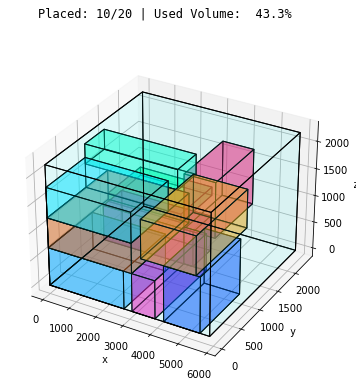

In [31]:

import time


for i in batch_states:
  env.render(i)
  time.sleep(0.2)
#print("Printed after 2.4 seconds.")



Advantage function.
where Q^π is the Q-value of state action pair (s, a), and Vᵩₖ is the value of some observation s determined by our critic network following parameters Φ on the k-th iteration.

In [ ]:
# next steps
# save visualization after end of each batch 
# understand func learn middle part again
# tune hyperparameters

In [7]:
%matplotlib inline
from matplotlib import rc
# Visualise the episode!
# You can go back to the previous cell and change the seed if you would like to see a different run.
rc('animation', html='jshtml') 
animation = env.animation(batch_states)
animation

AttributeError: ignored

In [10]:
import jax
import jax.numpy as jnp
import jumanji
from jumanji.wrappers import AutoResetWrapper
key = jax.random.PRNGKey(0)
env = jumanji.make("BinPack-toy-v0")
state, timestep = env.reset(0)
# Randomly choose ems_id and item_id using the action mask

num_ems, num_items = env.action_spec().num_values
ems_item_id = jax.random.choice(
    key=key,
    a=num_ems * num_items,
    p=timestep.observation.action_mask.flatten(),
)
ems_id, item_id = jnp.divmod(ems_item_id, num_items)

#Wrap the action as a jax array of shape (2,)
action = jnp.array([ems_id, item_id])
state, timestep = env.step(state, action)
print(timestep.reward)

/usr/local/lib/python3.8/dist-packages/jax/_src/numpy/lax_numpy.py:173: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have i

0.0


In [46]:
np.array(timestep.reward.flatten())[0]

0.0

In [33]:
p = flatten(timestep.observation)

NameError: ignored

In [12]:
p.shape

(380,)

In [6]:
type(timestep.observation)

jumanji.environments.combinatorial.binpack.types.Observation

In [7]:
timestep.observation.action_mask.flatten().shape

(800,)

In [ ]:
env.action_spec()

In [ ]:
env.observation_spec()

In [56]:
p.shape[0]

420

In [ ]:
#flatten observation  p = flatten(timestep.observation)
# inside critic and actor by converting it to np.array(p) by actor you will get action

In [61]:
model1 = FeedForwardNN(p.shape[0],800)
p1 = model1.forward(np.array(p))


inside tensor


In [62]:
model2 = FeedForwardNN(p.shape[0],1)
critic = model2.forward(np.array(p))

inside tensor


In [63]:
critic

tensor([0.], grad_fn=<ReluBackward0>)

In [64]:
p1

tensor([7.3258e-02, 4.7905e-03, 1.4326e-01, 8.5431e-02, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0771e-01, 2.3255e-02, 9.9250e-02, 7.8145e-02, 7.6100e-02,
        0.0000e+00, 2.0643e-01, 0.0000e+00, 6.3144e-02, 7.6659e-02, 0.0000e+00,
        0.0000e+00, 5.3319e-02, 2.9052e-01, 0.0000e+00, 1.1991e-01, 2.0213e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 5.0750e-02, 2.5038e-01, 7.0100e-02,
        0.0000e+00, 9.5201e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        6.2684e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        7.5674e-02, 2.9135e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9981e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.5849e-01, 2.9518e-02, 0.0000e+00,
        9.9162e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8625e-01, 1.6340e-01,
        0.0000e+00, 0.0000e+00, 1.0939e-01, 2.2355e-02, 0.0000e+00, 1.7597e-01,
        1.5238e-01, 4.5492e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.5950e-02,
        0.0000e+00, 1.7501e-01, 0.0000e+

In [65]:
p1.shape

torch.Size([800])

In [18]:
import pandas as pd
action_mask = timestep.observation.action_mask.flatten()


In [32]:
action_tensor = torch.tensor(np.array(action_mask),dtype=torch.int)

In [33]:
indices = torch.nonzero(action_tensor)  #getting valid indicies 

In [ ]:
import pandas as pd
action_mask = timestep.observation.action_mask.flatten()
action_tensor = torch.tensor(np.array(action_mask),dtype=torch.int)
indices = torch.nonzero(action_tensor)  #getting valid indicies 
p2 = p1[indices] # getting proper valid action probablities 

In [34]:
indices

tensor([[ 0],
        [ 1],
        [ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9],
        [10],
        [12],
        [13],
        [14],
        [15],
        [16],
        [17],
        [18],
        [19],
        [22],
        [23],
        [24],
        [26],
        [28],
        [29],
        [30],
        [32],
        [34],
        [35],
        [36],
        [37],
        [38],
        [39],
        [40],
        [41],
        [42],
        [44],
        [45],
        [47],
        [48],
        [50],
        [52],
        [53],
        [54],
        [57],
        [58]])

In [35]:
action_tensor[indices]

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=torch.int32)

In [72]:
p2 = p1[indices] # getting proper valid action probablities 

In [107]:
p1[indices]

tensor([[0.0733],
        [0.0048],
        [0.1433],
        [0.0854],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.1077],
        [0.0233],
        [0.0992],
        [0.0781],
        [0.0000],
        [0.2064],
        [0.0000],
        [0.0631],
        [0.0767],
        [0.0000],
        [0.0000],
        [0.0533],
        [0.1199],
        [0.2021],
        [0.0000],
        [0.0000],
        [0.2504],
        [0.0701],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0627],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0757],
        [0.0000],
        [0.0000],
        [0.1998],
        [0.0000],
        [0.0000],
        [0.0295],
        [0.0000],
        [0.0992],
        [0.0000],
        [0.1862]], grad_fn=<IndexBackward0>)

In [42]:
from torch.distributions import Categorical


In [90]:
p1.shape

torch.Size([800])

In [93]:
p2.shape

torch.Size([46, 1])

In [96]:
p2= torch.reshape(p2,(-1,))  # reshapping it to make it 1D

In [115]:
m = Categorical( logits = p2) #logits un-normalized probablities 
a=m.sample() #actions
m.log_prob(a) # softmax probablity of that action

tensor(-3.8186, grad_fn=<SqueezeBackward1>)

In [118]:
m.logits

tensor([-3.8081, -3.8765, -3.7381, -3.7959, -3.8813, -3.8813, -3.8813, -3.7736,
        -3.8581, -3.7821, -3.8032, -3.8813, -3.6749, -3.8813, -3.8182, -3.8047,
        -3.8813, -3.8813, -3.8280, -3.7614, -3.6792, -3.8813, -3.8813, -3.6309,
        -3.8112, -3.8813, -3.8813, -3.8813, -3.8813, -3.8186, -3.8813, -3.8813,
        -3.8813, -3.8813, -3.8813, -3.8056, -3.8813, -3.8813, -3.6815, -3.8813,
        -3.8813, -3.8518, -3.8813, -3.7821, -3.8813, -3.6951],
       grad_fn=<SubBackward0>)

In [120]:
a.item() 

29

In [122]:
indices[a.item()].item() # valid action value 

tensor([36])

In [ ]:
# # X = torch.tensor([0.1, 0.5, -1.0, 0, 1.2, 0])
# mask = action_mask == True
# mask
# tensor([1, 1, 0, 1, 1, 1], dtype=torch.uint8)

# >>> indices = torch.nonzero(mask)
# >>> indices
# tensor([[0],
#         [1],
#         [3],
#         [4],
#         [5]])

# >>> X[indices]
# tensor([[0.1000],
#         [0.5000],
#         [0.0000],
#         [1.2000],
#         [0.0000]])

In [35]:
ems_item_id

NameError: ignored

In [ ]:
action

DeviceArray([ 0, 11], dtype=int32)

In [ ]:
l = [ 0.25, 0.25, 0.25, 0.25 ]

In [ ]:
import torch
from torch.distributions import MultivariateNormal,Categorical
m = Categorical(torch.tensor(l))
m.sample()

tensor(3)

In [ ]:
l[3]

0.25